In [1]:
'''
In Version 2 wird versucht, beim Trainieren des Cubes diesen zu lösen und die Zwischenzustände als Input in das Netzwerk zu gebrauchen.
Begonnen: 7.2.2021

In Version 3 wird versucht, diese Routine zu perfektionieren, indem eine komplexere Lösungsroutine verwendet wird. Beim Training wird außerdem auf Queues zurückgegriffen
Begonnen: 14.2.2021

In Version 4 wurde vom faces-Format auf das pieces-Format umgestellt, wie es auch im Originalpaper verwendet wird. D. h. es werden Position und Orientierung der
Unterwürfel dem Netzwerk gegeben, statt der Position der Aufkleber. Das Netzwerk hatte bislang nicht gelernt, dass zusammenhängende Aufkleber nichts bringen,
wenn sie von einem falsch positionierten Unterwürfel kommen.

In Version 5 wurde Feintuning betrieben, durch eine hashtable konnte der solve vorgang minimal beschleunigt werden.

'''

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from rubiks_cube import *
from rubiks_helpers import *
#from rubiks_cube_pieces import *
from rubiks_cube_states import *
from tqdm.notebook import tqdm, trange
from functools import lru_cache


In [2]:
cube = RubiksCube(3)
#cube.getfaces()
cube.draw()

         +--------+
         | y y y  |
         | y y y  |
         | y y y  |
+--------+--------+--------+--------+
| g g g  | o o o  | b b b  | r r r  |
| g g g  | o o o  | b b b  | r r r  |
| g g g  | o o o  | b b b  | r r r  |
+--------+--------+--------+--------+
         | w w w  |
         | w w w  |
         | w w w  |
         +--------+



In [12]:

cube = RubiksCube()

for _ in tqdm(range(100)):
    cube.shuffle()
    state = cube2state(cube)
    m = np.random.choice(moves)
    cube.rotate(m)
    #cube.draw()
    state2 = cube2state(cube)
    state = apply(state, m)
    #draw(state)

    if not np.all(state == state2):
        print('Not all the same!')
        break
        

  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
from collections import defaultdict
hashtable = defaultdict(lambda: np.inf)

def add_to_dict_recursive(state=None, depth=0, maxdepth=6):
    if depth+1 > maxdepth:
        return
    if type(state) is type(None):
        state = newstate()
        d[state.tobytes()] = 0
    for m in moves:
        state2 = apply(state, m)
        s = state2.tobytes()
        d[s] = min(depth+1, d[s])
        add_to_dict(state2, depth+1, maxdepth)

def add_to_dict_iterative(maxdepth=6):
    hashtable = dict()
    mashtable = dict()
    if maxdepth<0:
        return hashtable, mashtable
    state = newstate()
    hashtable[state.tobytes()] = 0
    thisdepth = [(state, '')]
    nextdepth = []
    depth = 0
    while depth < maxdepth:
        for state0, m0 in thisdepth:
            for m in moves:
                state = apply(state0, m)
                s = state.tobytes()
                if s in hashtable:  # falls state2 bereits im algorithmus vorkam, kann der neue wert nicht kleiner sein
                    continue
                else:
                    hashtable[s] = depth+1
                    mashtable[s] = m0 + m
                    nextdepth.append((state, m0+m))
        # vorbereitung für nächste iteration
        thisdepth = nextdepth
        nextdepth = []
        depth += 1
    return hashtable, mashtable
        
hashed_depth = -1##
%time _hashtable, mashtable = add_to_dict_iterative(hashed_depth)
print(f'Created hashtable of length {len(_hashtable)}')
hashtable = _hashtable

KeyboardInterrupt: 

Created hashtable of length 0


In [ ]:
state = newstate()
state = apply(state, 'F')
s = state.tobytes()
#%timeit s in d
hashtable[s], mashtable[s]

In [8]:
state = newstate()
state = apply(state, 'L')
state = apply(state, 'U')
state = augment(state)
draw(state)


KeyboardInterrupt: 

In [6]:
# real world randomly shuffled cube
input = \
''' gyr
    oyb
    yyr
ywo bgw gyb woo
ogg rob wby rrg
rww orr yrw goy
    bbg
    gww
    bbo
'''

cube.fromstring(input)
cube.draw()

mystate = cube2state(cube)

         +--------+
         | g y r  |
         | o y b  |
         | y y r  |
+--------+--------+--------+--------+
| y w o  | b g w  | g y b  | w o o  |
| o g g  | r o b  | w b y  | r r g  |
| r w w  | o r r  | y r w  | g o y  |
+--------+--------+--------+--------+
         | b b g  |
         | g w w  |
         | b b o  |
         +--------+



In [7]:
cube.reset()
cube.rotate('U U F U U r L F F U f b R L U U R U d R l D r l D D')
#cube.draw()
mystate26 = cube2state(cube) # takes 26 moves to solve

## Neuronales Netzwerk ansetzen

In [8]:
import torch
from torch import nn
import pickle

In [10]:
from net import Net as Net
from net import inference_speed

MSE = nn.MSELoss()
L1Loss = nn.L1Loss()
L1L2 = lambda x, y: MSE(x,y) + L1Loss(x,y)
#LogLoss = lambda pp, pt: torch.mean(-pt*torch.log(pp+1e-4))
LogLoss = nn.NLLLoss() # for non-onehot
BCELoss = nn.BCELoss()
        
    

    
net = Net()
net_teacher = net

# der zeitaufwand für evaluation ist konstant bis n=1000 (1.15ms)
# und ab n=5000 (4.57ms) steigt er linear an, d. h. das Verhältnis ist konstant

In [11]:
inference_speed(net)

(3.7396740913391113, 1.2206363677978516)

In [ ]:
# Netzwerk laden
d = None
for ep in range(1000, -1, -1):
    try:
        fn = f'data/rubik_ep{ep}.dat'
        d = torch.load(fn)
        print(f'Loading Network form path "{fn}"')
        break
    except:
        continue
else:
    print('Couldnt load!')
        
net = Net()
if d:
    net.load_state_dict(d, strict=False)
net.iter = 1000*ep+1
net_teacher = net

In [12]:
_shuffled_cubes = None


def bg_inf():
    global _shuffled_cubes
    if type(_shuffled_cubes) is type(None):
        _shuffled_cubes = [ shuffle() for _ in range(100) ]
        
    k = np.random.randint(100)
    _shuffled_cubes[k] = shuffle(_shuffled_cubes[k], 10)
    return _shuffled_cubes[k]


def bg_shuffle():
    if np.random.rand() < 0.5: # entspricht bginf (unendlich oft verdrehter Würfel)
        return bg_inf()
    else:   # entspricht bg20 (bis zu 30 mal verdrehter Würfel)
        return shuffle(n=np.random.randint(30))

def bg_shuffle_num(nmax=50):
    n = np.random.randint(nmax)
    return shuffle(n=n), n

In [13]:

npsolved = state2oh(newstate())
tsolved = np2t(npsolved)

'''
np.random.seed(0)
valbatch_x, valbatch_z = [], []
for k in range(1000):
    state = shuffle(n=min(k+1, 100))
    valbatch_x.append(pieces2oh(state))
    zs = [ pieces2oh(apply(state, moves[i])) for i in range(12) ]
    valbatch_z.append(zs)
valbatch_x = np.array(valbatch_x)
valbatch_z = np.array(valbatch_z)''';
    
'''
def printValStats(withplot=True):
    'Prints all validation statistics'
    
    xs, zs = valbatch_x, valbatch_z
    xs = np2t(xs)
    zs = np2t(zs)
    
    # Validation loss
    with torch.no_grad():
        values = [t2np(net_teacher(zs[:,r], policy=False)) for r in range(12)] # do all 12 rotations to see the values of the following positions
    policy = np.argmin(values, axis=0)
    pt = policy2oh(policy)
    values = np.min(values, axis=0) # axis for the moves is now axis 0
    pt = np2t(pt, dtype='int64')
    vt = np2t(values+1)
    vp, pp = net(xs)
    #print(pp.shape, pt.shape) # = torch.Size([1500, 12]) torch.Size([1500, 12])
    loss_p = LogLoss(pp, pt[:,0])
    loss_v = MSE(vp, vt)
    acc_p = (policy[:,0] == np.argmax(t2np(pp), axis=1)).mean()
    vdist = [ t2np(vp[k]) - values[k] for k in range(len(values))]
    print(f'ValLoss p: {loss_p: .3f}, ValLoss v: {loss_v: .3f}, ValAcc p: {acc_p: .3f}')
    print(f'ValProbability to hit min:', np.mean([np.exp(t2np(pp[k, policy[k,0]])) for k in range(len(policy))]))
    print(f'Val stuck: {np.mean([d < 0 for d in vdist]): .3f}')
    
    if withplot:
        # Graphics of Value going down, playing
        allvs, allss = [], []
        #for k in range(500, 1000, 100):
        for k in range(3, 21, 2):
            state = oh2pieces(valbatch_x[k])
            cube = RubiksCube()
            cube.frompieces(state)

            moves = ['F', 'B', 'R', 'L', 'U', 'D'] + ['f', 'b', 'r', 'l', 'u', 'd']
            moves_rev = { k: m for k, m in enumerate(moves) }

            lastv = np.Inf
            thisvs = []
            thisss = []
            for _ in range(100):
                oh = pieces2oh(state)
                oh = np2t(oh[None,:])
                v, p, s = net(oh, solvable=True)
                v, s = v.item(), s.item()

                if cube.issolved():
                    thisvs.append(0.)
                    thisss.append(10.)
                    break
                else:
                    thisvs.append(v)
                    thisss.append(s*10)

                if v >= lastv:
                    break
                lastv = v

                # Way 1: Move by prediction p
                if False:
                    p = t2np(p)
                    m = moves_rev[p.argmax()]
                # Way 2: Move by minimizing next moves v
                else:
                    vs = []
                    for m in moves:
                        cb = cube.copy()
                        cb.rotate(m)
                        state = cb.getpieces()
                        oh = pieces2oh(state)
                        oh = numpy2torch(oh[None,:])
                        vs.append(net(oh, policy=False))
                    m = moves[np.argmin(vs)]

                cube.rotate(m)
                state = cube.getpieces()
            allvs.append(thisvs)
            allss.append(thisss)

        for thisvs in allvs:
            plt.plot(thisvs)
        #for thisss in allss:
        #    plt.plot(thisss, '--')
        plt.show()
        
    return loss_p, loss_v, acc_p''';

In [14]:

npsolved = state2oh(newstate())
tsolved = np2t(npsolved)

np.random.seed(0)
valstates = [ [ shuffle(n=k) for _ in range(10) ] for k in range(2,30,2) ]
valstates100 = [ shuffle(n=100) for _ in range(20) ]

def ValStats(trials=100, extra=False):
    'Prints all validation statistics'
    
    net.eval()
    cube = RubiksCube()
    
    N = len(valstates)
    M = len(valstates[0])
    
    # Direct / naive solving strategy
    allstat = []
    for k in range(N):
        thisstat = [] # statistics for fixed k, i. e. number of shuffle moves
        for n in range(M):
            state = valstates[k][n]
            lastv = np.Inf
            while True:
                oh = state2oh(state)
                oh = np2t(oh[None,:])
                v = net(oh)
                v = v.item()

                if issolved(state):
                    thisstat += [True]
                    break

                if v >= lastv:
                    thisstat += [False]
                    break
                    
                lastv = v

                # Move by minimizing next moves v
                vs = []
                for m in moves:
                    fellow = apply(state, m)
                    oh = state2oh(fellow)
                    oh = numpy2torch(oh[None,:])
                    vs.append(net(oh, policy=False))
                m = moves[np.argmin(vs)]

                state = apply(state, m)
                #print(m)
                #draw(state)
                
        allstat += [ np.mean(thisstat) ]
    
    plt.bar(np.arange(2,30,2), allstat)
    
    # More sophisticated solve strategy
    allstat = []
    for k in range(N):
        thisstat = [] # statistics for fixed k, i. e. number of shuffle moves
        for n in range(M):
            state = valstates[k][n]
            solved, _ = solve_train(state, enqueue=False, trials=trials)
            thisstat += [ solved ]
        allstat += [ np.mean(thisstat) ]
        
    plt.bar(np.arange(2+1,30+1,2), allstat, color='C2')
    plt.show()
    
    # Graph with estimated v over real v (shuffle depth)
    ns = []
    vs = []
    for k in range(N):
        for n in range(M):
            state = valstates[k][n]
            oh = state2oh(state)
            oh = np2t(oh[None,:])
            v = net(oh, policy=False)
            v = v.item()
            ns.append(2*k+2)
            vs.append(v)
    plt.scatter(ns, vs, s=2)
    plt.show()
    
    net.train()
    
    if extra:
        # Wie oft wird der 100fach verdrehte Würfel gelöst in maximal 1000 trials?
        states_solved = []
        for state in valstates100:
            res = solve(state, verbose=0, maxlen=26, trials=5000)
            if res['l'] == -1:
                states_solved.append(False)
            else:
                states_solved.append(True)
        net.stats.append((net.iter, np.mean(states_solved)))

        if len(net.stats) > 0:
            plt.plot([t for t, x in net.stats], [x for t, x in net.stats])
            plt.show()

In [15]:
def fellow_vs(xs, nrots=1, static=True):
    '''Generates the fellow states vs for a batch of states xs
    nrots: Number of rotations, i. e. the depth'''
    
    bnum = len(xs)
    # Auf jeden Würfel in xs die zwölf Züge anwenden und in zs speichern
    # moves = ['F', 'B', 'R', 'L', 'U', 'D'] + ['f', 'b', 'r', 'l', 'u', 'd']
    zs = np.zeros((bnum, 12**nrots,)+shape_state)
    for b in range(bnum):
        state0 = oh2state(xs[b])
        for r in range(12**nrots):
            state = state0.copy()
            ms = ''
            n = r
            for l in range(nrots):
                m = moves[n%12]
                ms += m
                n = n//12
                state = apply(state, m)
            oh = state2oh(state)
            zs[b, r] = oh

    zs_in = np2t(zs)
    zs_in = zs_in.view(-1, *shape_state) # all rotations into batch dimension
    # Auf zs das Netzwerk anwenden und die Values in vs speichern (Vorhersage des Netzwerkes für den 'Wert' eines Status, d.h. wie nahe ein Status an dem gelösten Cube ist.)
    if static:
        with torch.no_grad():
            vsraw = net_teacher(zs_in, policy=False)
    else:
        vsraw = net(zs_in, policy=False)
    vsraw = t2np(vsraw[:].view(-1, 12**nrots))
    ssraw = None
    
    return vsraw, ssraw, zs

In [16]:

        
        
def train_on_samples(samples, weight=0.2):
    'Trains the net on the samples by evaluating on their 12 fellow states, taking min and targeting min+1 for the original state.'
    if len(samples)==0: return 0
    xs = np.array(samples)
    vsraw, ssraw, zs = fellow_vs(xs)
    
    
    
    ##### TESTPHASE: hashen von wenigen states                          #####
    for b in range(bnum):
        state = oh2state(xs[b])
        for r in range(len(moves)):
            state2 = apply(state, moves[r])
            s2 = state.tobytes()
            if s2 in hashtable:
                vsraw[b,r] = hashtable[s2]
    ##### END TESTPHASE
    

    # policies bestimmen und values bestimmen
    ps = np.argmin(vsraw, axis=1)
    vs = np.min(vsraw, axis=1)[:,None]

    # Netzwerk lernen lassen durch die xs und (vs, ps)
    pred_vs = net(np2t(xs))
    loss_p = 0
    loss_v = L1L2(pred_vs, np2t(vs + 1))
    loss = loss_p + loss_v
    loss *= weight
    loss.backward()
    return

def train_to_target(samples, weight=0.2, greaterthan=True):
    'Trains the net by giving the states a hard target for the output v. Used for the stuck states'
    if len(samples)==0: return 0
    xs = np.array([ state2oh(x) for x, v in samples ])
    vs = np.array([ v for x, v in samples ])
    pred_vs = net(np2t(xs), policy=False, solvable=False)[:,0]
    if greaterthan:   # nur sicher stellen, dass prediction >= target ist
        loss = torch.mean(torch.max(np2t(vs)-pred_vs, torch.zeros_like(pred_vs)))
    else:             # per L1Loss auf das target hintrainieren
        loss = L1Loss(pred_vs, np2t(vs))
    loss *= weight
    loss.backward()
    return loss

def train_solvable(samples, weight=0.2):
    if len(samples)==0: return 0
    xs = np.array([ state2oh(x) for x, s in samples ])
    ss = np.array([ s for x, s in samples ])
    ss = 0.98*ss+0.01
    pred_ss = net(np2t(xs), value=False, policy=False, solvable=True)[:,0]
    loss = BCELoss(pred_ss, np2t(ss))
    loss *= weight
    loss.backward()
    return loss


class Queue:
    samples = []  # samples
    trained_on = []
    tau = 0.99
    lastN = 0
    def __init__(self):
        self.trainfunction = train_on_samples # override this if you use train() to train the network
    def add(self, x):
        'Adds the stuck samples and deletes some older samples'
        self.samples = self.samples + [x]
        self.trained_on = self.trained_on + [0]
    def discount(self):
        k = int(len(self.samples)*(1-self.tau))
        self.samples = self.samples[k:]
        self.trained_on = self.trained_on[k:]
        #print(len(self.samples))
    def get(self, n):
        self.lastN = n
        res = []
        l = len(self.samples)
        if l <= n:  # wenn zu wenige samples, die komplette queue übergeben
            res = self.samples
        else:
            for i in range(n):
                j = np.random.randint(len(self.samples))
                res.append(self.samples[j])
        return res
    def train(self, n, weight=0.2):
        'Trains the nn on a number of samples'
        if len(self) < n:
            return 0
        return self.trainfunction(self.get(n), weight=weight)
    def __len__(self):
        return len(self.samples)
    @property
    def perIter(self): # wie viele neue pro iteration hinzukommen
        T = 1/(1-self.tau)
        return len(self) / T
    @property
    def nTrainsPerSamples(self): # wie oft ein sample insgesamt trainiert wird
        return self.lastN / (self.perIter+1e-3)
    
    
class Queue_Hardvalues(Queue):
    'Queue allowing training on hard values'
    def __init__(self):
        self.trainfunction = train_to_target
        
class Queue_Solvable(Queue):
    def __init__(self):
        self.trainfunction = train_solvable
        

In [17]:

queue_stuck = Queue_Hardvalues()
queue_stuck.tau = .99

queue_while_solving = Queue()
queue_while_solving.tau = 1 - 1 / 10000 # <-- 10000 iterationen lang beibehalten

        
def bg_stuck():
    'Eine art pseudo batch generator, der einen State ausgibt der als stuck identifiziert wurde.'
    if len(queue_stuck) > 0:
        return queue_stuck.get(1)[0][0]
    else:
        return bg_shuffle()
    
def bg_whilesolving():
    if len(queue_while_solving) > 0:
        return queue_while_solving.get(1)[0]
    else:
        return bg_shuffle()
    
def bg_mixed():
    if np.random.rand() < 0.5 and len(queue_while_solving) > 1000:
        return bg_whilesolving()
    else:
        return bg_shuffle()
    

        
def target_bfs(state0, depth=3):
    '''Performs a breadth first search with the state to a given depth. Returns the target value for the state (generalization of min v_m + 1)'''
    ms2s = dict() # translates moves to a state
    explored = set()
    ms2s[''] = state0
    zs = []
    for d in range(1, depth+1):
        keys = list(ms2s.keys())
        for ms in keys:
            if len(ms)!=d-1: continue
            state = ms2s[ms]
            for m in moves:
                z = apply(state, m)
                if issolved(z):
                    return d
                if z.tobytes() in explored:
                    continue
                explored.add(z.tobytes())
                ms2s[ms+m] = z
                if d==depth:
                    zs.append(state2oh(z))
    
    vtarget = np.inf
    N = 1000
    mbs = [ zs[N*i:N*(i+1)] for i in range(len(zs)//N+1)]
    for mb in mbs:
        mb = np2t(np.array(mb))
        vs = net_teacher(mb, policy=False)
        vs = t2np(vs)
        vtarget = min(vtarget, np.min(vs) + d) # this is a generalization of: vtarget = min(vs) + 1
    #print(f'd={d}, vtarget = {vtarget}')
            
    return vtarget
        
        
def target_bfs_sloppy(state0, depth=3, num=3):
    '''Sloppy Version: Only takes the three most favourite moves --> 3**d instead of 12**d states to evaluate'''
    ms2s = dict() # translates moves to a state
    explored = set()
    ms2s[''] = state0
    zs = []
    for d in range(1, depth+1):
        keys = list(ms2s.keys())
        for ms in keys:
            if len(ms)!=d-1: continue
            state = ms2s[ms]
            p = net_teacher(np2t(state2oh(state))[None,:], value=False, policy=True)[0,:]
            inds = argmax(t2np(p), num=num)
            for m in [moves[i] for i in inds]:
                z = apply(state, m)
                if issolved(z):
                    return d
                if z.tobytes() in explored:
                    continue
                explored.add(z.tobytes())
                ms2s[ms+m] = z
                if d==depth:
                    zs.append(state2oh(z))
    
    vtarget = np.inf
    N = 1000
    mbs = [ zs[N*i:N*(i+1)] for i in range(len(zs)//N+1)]
    for mb in mbs:
        mb = np2t(np.array(mb))
        vs = net(mb, policy=False)
        vs = t2np(vs)
        vtarget = min(vtarget, np.min(vs) + d) # this is a generalization of: vtarget = min(vs) + 1
    #print(f'd={d}, vtarget = {vtarget}')
            
    return vtarget


def add_to_stuck_queue(state, depth=3, naug=10):
    # When finding a stuck state, we want to do a deeper search for the v value and add the state to a queue which
    # trains the sample on this hard value v.
    for _ in range(naug):
        state = augment(state)
        v = target_bfs(state, depth=depth) - 0.5 # halber zug puffer, da statisch
        queue_stuck.add((state, v))
    ##print(f'Stuck states target value now is {v}')
    
def add_to_whilesolving_queue(state):
    state = augment(state)
    queue_while_solving.add(state)

In [18]:

    
def solve_train(state0, trials=1000, verbose=False, enqueue=True, ratio_ws=0.2, batchsize=10):
    '''While training, this function tries to solve a cube and records many stuck states and records if a state was solvable or not within an amount of trials'''
    # batchsize von > 10 kann suboptimale sein und bringt keinen geschwindigkeitsvorteil(?)
    
    def verb(*args):
        if verbose: print(*args)
    
    @lru_cache(None)
    def penalty(l, t):
        #return log(l+1)*t*15 # return penalty dependent on parameter t
        return 0.8*l*t # return penalty dependent on parameter t
        
    def penalties(v, ms):
        l = len(ms)
        return [v + penalty(l, t) for t in np.arange(0, 1, 1/5)]
    
    try: state0 = oh2state(state0)
    except: pass
    
    v0 = net(np2t(state2oh(state0)[None,:]), policy=False).item()
    
    explored = set()
    queue = SolvingQueue(n=5)
    queue.push(item=(state0, v0, ''), values=5*[0])
    
    basestate0 = state0
    
    iter = 0
    
    maxlen = np.inf
    
    while len(queue)>0:

        bsize = min(batchsize, len(queue)) # batch size is small at the beginning and can become bigger
        oldvs = []
        newstates = []
        ms = []

        for b in range(bsize):

            while True:
                state0, v0, m0 = queue.pop(iter%5)
                if len(m0) + 0.8*v0 - 0.5 < maxlen: # erwartete lösungslänge vs. erlaubtes maximum
                    break

            verb(f'Iteration {iter}, Moves {m0} applied, Value = {v0}, len(queue) = {len(queue)}!')

            if iter%22==0 and b==0 and verbose>=2: draw(state0)

            if state0.tobytes() in hashtable:
                return True, m0
            
            if issolved(state0):
                return True, m0

            # Auf jeden Würfel in xs die zwölf Züge anwenden und in zs speichern
            for m in moves:
                state = apply(state0, m)
                newstates.append(state)
                ms.append(m0+m)
                if enqueue and np.random.rand()<ratio_ws:
                    add_to_whilesolving_queue(state0)
            oldvs.append(v0)

            iter += 1


            if iter > trials:
                #if enqueue: queue_solved.add((pieces2oh(base_state0), False)) # not solved
                return False, None


        # Auf zs das Netzwerk anwenden und die Values in vs speichern (Vorhersage des Netzwerkes für den 'Wert' eines Status, d.h. wie nahe ein Status an dem gelösten Cube ist.)
        zs = np.array([ state2oh(s) for s in newstates ])
        with torch.no_grad():
            zs = np2t(zs)
            vsnext = net(zs, policy=False)
            vsnext  = t2np(vsnext[:,0])

        # Falls stuck, dann melden
        if np.min(vsnext[12*b:12*(b+1)]) > oldvs[b]:
            verb(Back.RED+f'Adding stuck state with v={oldvs[b]}'+Back.RESET)
            ##print(f'Stuck state has old value {v0}!')
            if enqueue: add_to_stuck_queue(state0)

        # Neue States der Queue hinzufügen
        for k in range(12*bsize):
            if newstates[k].tobytes() in explored:
                continue
            else:
                explored.add(newstates[k].tobytes())
                queue.push(item=(newstates[k], vsnext[k], ms[k]), values=penalties(vsnext[k], ms[k]))


In [19]:
def train_upper_limit(num=100, weight=0.5):
    ''
    ns = np.random.randint(15, size=num)
    states = [ shuffle(n=n) for n in ns ]
    ohs = np2t(np.array([ state2oh(s) for s in states ]))
    vs = net(ohs, policy=False)[:,0]
    
    ns = np2t(ns, dtype='float32')
    loss = torch.mean(torch.max(vs-ns, torch.zeros_like(vs)))
    loss *= weight
    loss.backward()
    return loss


def train_lower_limit(num=100, weight=0.5):
    'BRAND NEU!'
    ns = np.random.randint(15, size=num)
    states = [ shuffle(mystate26, n=n) for n in ns ]
    ohs = np2t(np.array([ state2oh(s) for s in states ]))
    vs = net(ohs, policy=False)[:,0]
    
    ns = 26-ns
    
    ns = np2t(ns, dtype='float32')
    loss = torch.mean(torch.max(-(vs-ns), torch.zeros_like(vs)))
    loss *= weight
    loss.backward()
    return loss
    

def train_ssl_consistency(n=100, weight=0.2):
    'Train a augmentation consistency for only some symmetries'
    
    states1 = [ bg_shuffle() for _ in range(n) ]
    
    states2 = []
    for state in states1:
        states2.append(augment(state))
        
    xs = np2t(Bstate2oh(np.array(states1 + states2)))
    vs = net(xs, policy=False)
    vs1, vs2 = vs[:n], vs[n:]
    loss = weight * MSE(vs1, vs2)
    loss.backward()
    
    return loss


def train_by_ordering(n=100, weight=0.5):
    'Train by comparing two samples'
    nums = []
    states = []
    for i in range(n//2):
        state1, num1 = bg_shuffle_num()
        state2, num2 = bg_shuffle_num()
        if num1 < num2:
            state1, state2 = state2, state1
        states += [state1, state2]
    xs = np2t(Bstate2oh(np.array(states)))
    vs = net(xs, policy=False)
    loss = weight * vs * # .......................................................... (alternating between -1 and +1 as torch vector)
    return loss

In [ ]:
# Ersten Satz von while_solving samples laden, wenn netzwerk geladen wird
if net.iter > 1000 and len(queue_while_solving)<1000:
    with open('data/queue_while_solving.pkl', 'rb') as f:
        queue_while_solving.samples = pickle.load(f)
    with open('data/queue_stuck.pkl', 'rb') as f:
        queue_stuck.samples = pickle.load(f)
    print('Loaded samples from file')
else:
    print('Didnt load samples')

In [ ]:
net = Net()

queue_stuck = Queue_Hardvalues()
queue_stuck.tau = .99

queue_while_solving = Queue()
queue_while_solving.tau = 1 - 1 / 10000 # <-- 10000 iterationen lang beibehalten


  0%|          | 1/9999999999 [00:00<?, ?it/s]

Iteration 100
Loss v:  6.194, Loss p:  0.000, Loss s:  nan, Loss ssl:  0.157, Acc p:  1.000, Acc s:  nan    V Distance (target is +1):  1.395, std is:  1.446
Solved:  0.026
Length of Queue Hardlearner/Fellows/Stuck/WhileSolving: 10816 / 35719 / 0 / 0
Train Times of Queue Hardlearner/Fellows/Stuck/WhileSolving:  9.2 /  1.4 /  0.0 /  0.0


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


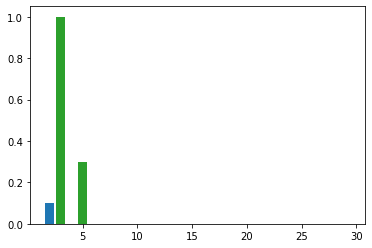

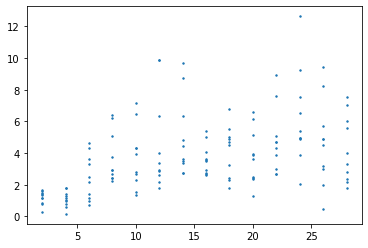

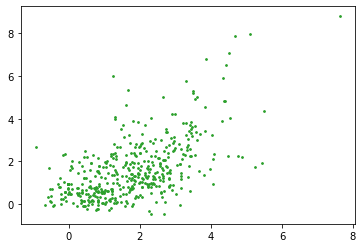

Iteration 200
Loss v:  2.884, Loss p:  0.000, Loss s:  nan, Loss ssl:  0.216, Acc p:  1.000, Acc s:  nan    V Distance (target is +1):  0.707, std is:  0.740
Solved:  0.030
Length of Queue Hardlearner/Fellows/Stuck/WhileSolving: 13402 / 40498 / 0 / 0
Train Times of Queue Hardlearner/Fellows/Stuck/WhileSolving:  7.5 /  1.2 /  0.0 /  0.0


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


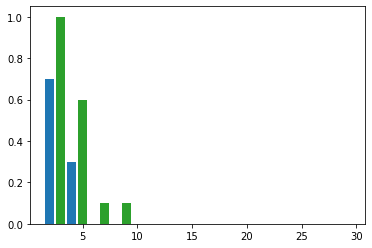

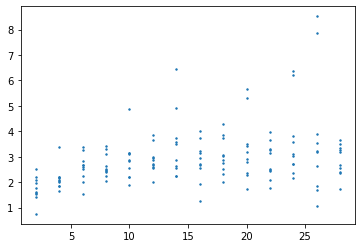

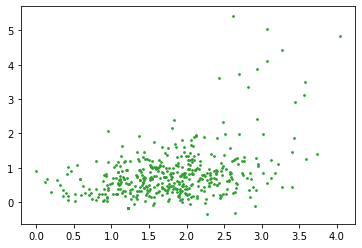

Iteration 300
Loss v:  0.829, Loss p:  0.000, Loss s:  nan, Loss ssl:  0.035, Acc p:  1.000, Acc s:  nan    V Distance (target is +1):  0.868, std is:  0.447
Solved:  0.061
Length of Queue Hardlearner/Fellows/Stuck/WhileSolving: 11450 / 17140 / 0 / 0
Train Times of Queue Hardlearner/Fellows/Stuck/WhileSolving:  8.7 /  2.9 /  0.0 /  0.0


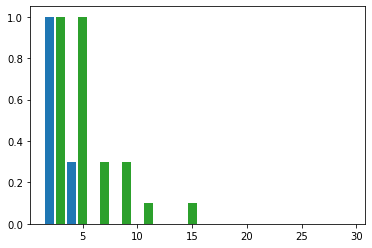

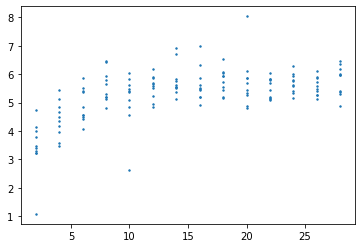

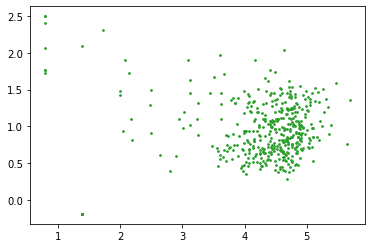

Iteration 400
Loss v:  0.756, Loss p:  0.000, Loss s:  nan, Loss ssl:  0.017, Acc p:  1.000, Acc s:  nan    V Distance (target is +1):  0.751, std is:  0.636
Solved:  0.081
Length of Queue Hardlearner/Fellows/Stuck/WhileSolving: 10699 / 14806 / 0 / 0
Train Times of Queue Hardlearner/Fellows/Stuck/WhileSolving:  9.3 /  3.4 /  0.0 /  0.0


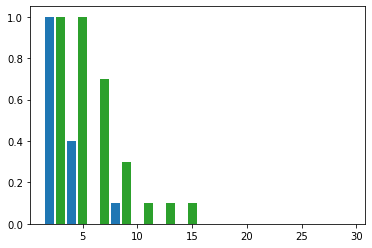

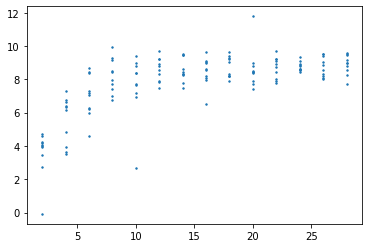

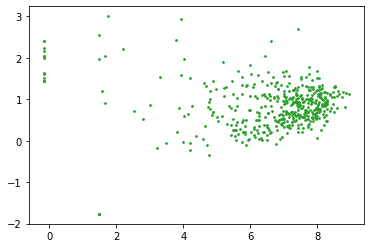

Iteration 500
Loss v:  1.052, Loss p:  0.000, Loss s:  nan, Loss ssl:  0.016, Acc p:  1.000, Acc s:  nan    V Distance (target is +1):  0.763, std is:  0.610
Solved:  0.083
Length of Queue Hardlearner/Fellows/Stuck/WhileSolving: 13564 / 32325 / 0 / 0
Train Times of Queue Hardlearner/Fellows/Stuck/WhileSolving:  7.4 /  1.5 /  0.0 /  0.0


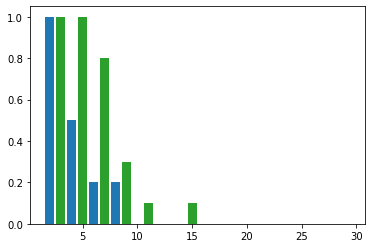

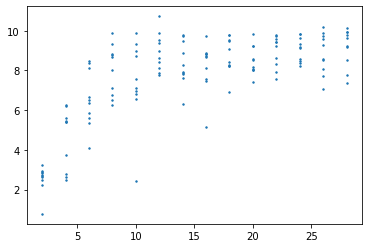

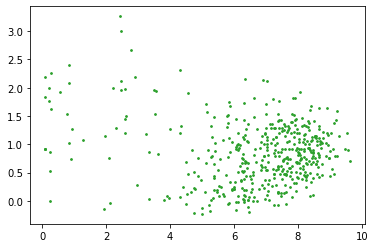

Iteration 600
Loss v:  0.889, Loss p:  0.000, Loss s:  nan, Loss ssl:  0.016, Acc p:  1.000, Acc s:  nan    V Distance (target is +1):  0.602, std is:  0.531
Solved:  0.075
Length of Queue Hardlearner/Fellows/Stuck/WhileSolving: 14031 / 30312 / 0 / 0
Train Times of Queue Hardlearner/Fellows/Stuck/WhileSolving:  7.1 /  1.6 /  0.0 /  0.0


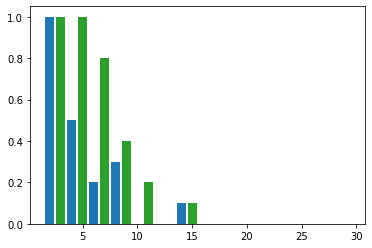

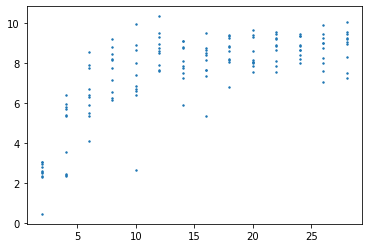

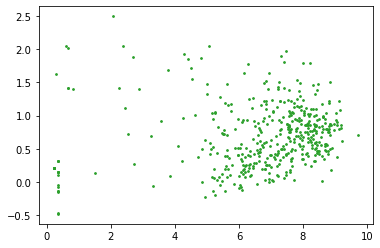

Iteration 700
Loss v:  0.845, Loss p:  0.000, Loss s:  nan, Loss ssl:  0.015, Acc p:  1.000, Acc s:  nan    V Distance (target is +1):  0.841, std is:  0.528
Solved:  0.094
Length of Queue Hardlearner/Fellows/Stuck/WhileSolving: 13760 / 28326 / 0 / 0
Train Times of Queue Hardlearner/Fellows/Stuck/WhileSolving:  7.3 /  1.8 /  0.0 /  0.0


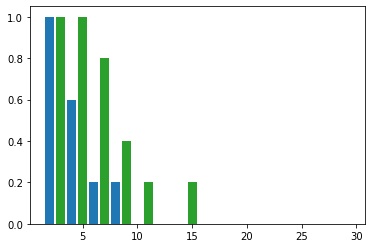

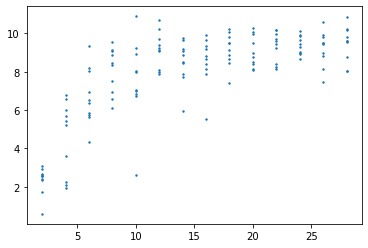

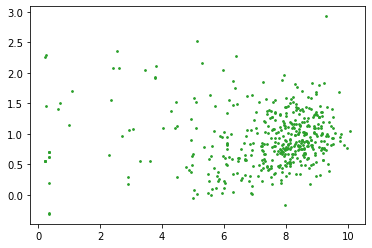

Iteration 800
Loss v:  0.811, Loss p:  0.000, Loss s:  nan, Loss ssl:  0.013, Acc p:  1.000, Acc s:  nan    V Distance (target is +1):  0.959, std is:  0.541
Solved:  0.082
Length of Queue Hardlearner/Fellows/Stuck/WhileSolving: 13098 / 25563 / 0 / 0
Train Times of Queue Hardlearner/Fellows/Stuck/WhileSolving:  7.6 /  2.0 /  0.0 /  0.0


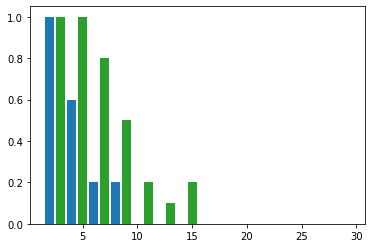

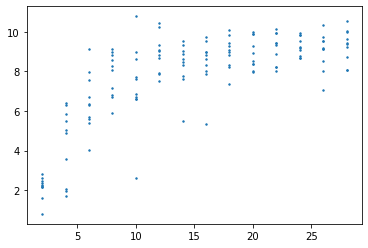

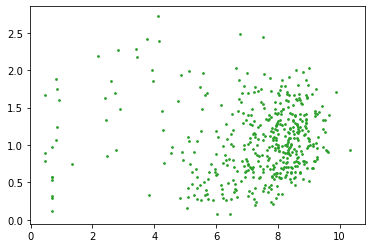

Iteration 900
Loss v:  0.744, Loss p:  0.000, Loss s:  nan, Loss ssl:  0.014, Acc p:  1.000, Acc s:  nan    V Distance (target is +1):  0.750, std is:  0.513
Solved:  0.100
Length of Queue Hardlearner/Fellows/Stuck/WhileSolving: 12288 / 19092 / 0 / 0
Train Times of Queue Hardlearner/Fellows/Stuck/WhileSolving:  8.1 /  2.6 /  0.0 /  0.0


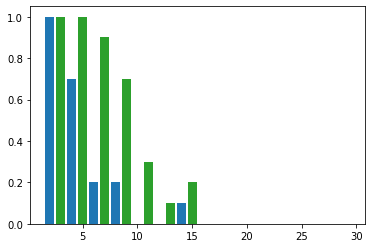

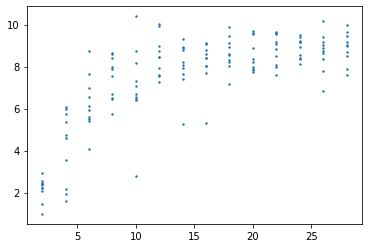

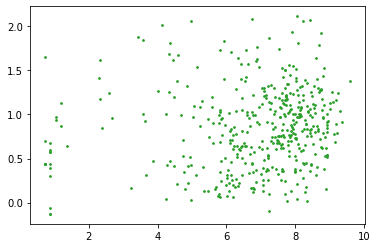

Iteration 1000
Loss v:  0.700, Loss p:  0.000, Loss s:  nan, Loss ssl:  0.014, Acc p:  1.000, Acc s:  nan    V Distance (target is +1):  0.775, std is:  0.465
Solved:  0.090
Length of Queue Hardlearner/Fellows/Stuck/WhileSolving: 11659 / 13178 / 0 / 0
Train Times of Queue Hardlearner/Fellows/Stuck/WhileSolving:  8.6 /  3.8 /  0.0 /  0.0


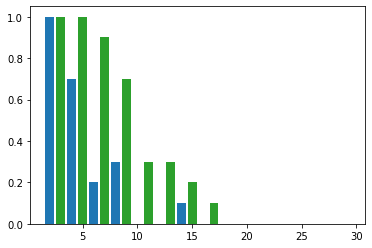

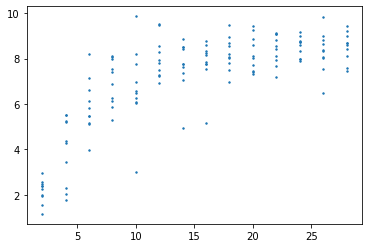

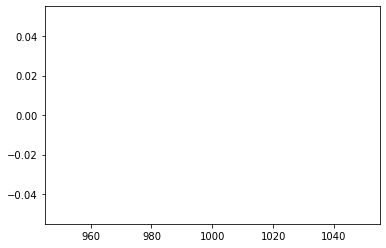

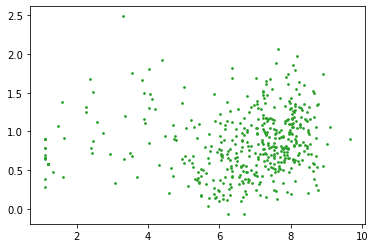

Saved to data/EXP_rubik_ep1.dat
Iteration 1100
Loss v:  0.689, Loss p:  0.000, Loss s:  nan, Loss ssl:  0.012, Acc p:  1.000, Acc s:  nan    V Distance (target is +1):  0.636, std is:  0.454
Solved:  0.112
Length of Queue Hardlearner/Fellows/Stuck/WhileSolving: 11420 / 9816 / 0 / 0
Train Times of Queue Hardlearner/Fellows/Stuck/WhileSolving:  8.8 /  5.1 /  0.0 /  0.0


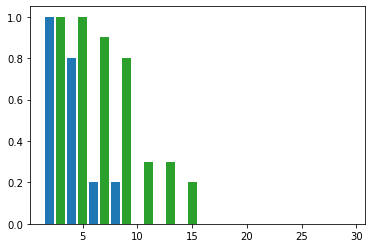

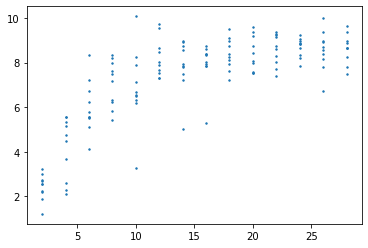

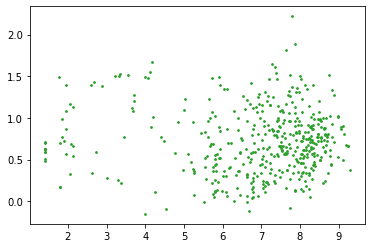

Iteration 1200
Loss v:  0.682, Loss p:  0.000, Loss s:  nan, Loss ssl:  0.011, Acc p:  1.000, Acc s:  nan    V Distance (target is +1):  0.907, std is:  0.482
Solved:  0.118
Length of Queue Hardlearner/Fellows/Stuck/WhileSolving: 11425 / 9155 / 0 / 0
Train Times of Queue Hardlearner/Fellows/Stuck/WhileSolving:  8.8 /  5.5 /  0.0 /  0.0


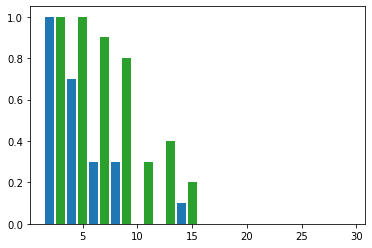

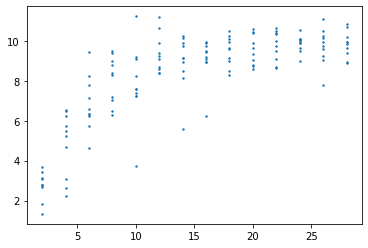

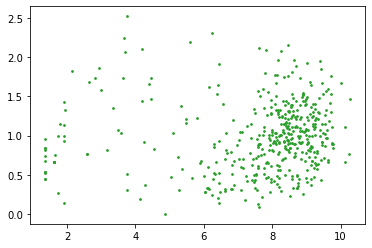

Iteration 1300
Loss v:  0.735, Loss p:  0.000, Loss s:  nan, Loss ssl:  0.013, Acc p:  1.000, Acc s:  nan    V Distance (target is +1):  0.888, std is:  0.580
Solved:  0.119
Length of Queue Hardlearner/Fellows/Stuck/WhileSolving: 11172 / 13258 / 0 / 0
Train Times of Queue Hardlearner/Fellows/Stuck/WhileSolving:  9.0 /  3.8 /  0.0 /  0.0


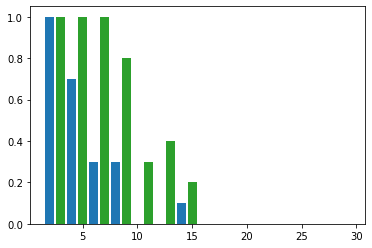

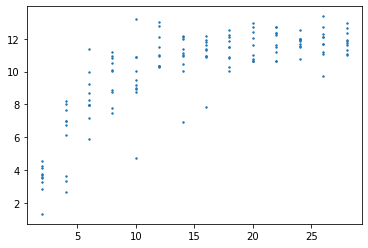

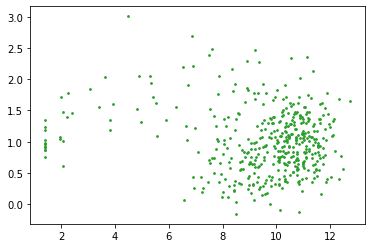

Iteration 1400
Loss v:  0.909, Loss p:  0.000, Loss s:  nan, Loss ssl:  0.019, Acc p:  1.000, Acc s:  nan    V Distance (target is +1):  1.021, std is:  0.662
Solved:  0.129
Length of Queue Hardlearner/Fellows/Stuck/WhileSolving: 11334 / 20217 / 0 / 0
Train Times of Queue Hardlearner/Fellows/Stuck/WhileSolving:  8.8 /  2.5 /  0.0 /  0.0


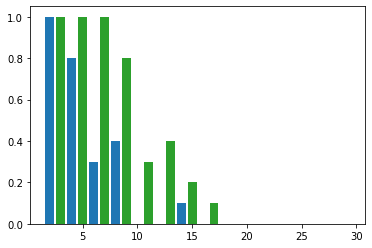

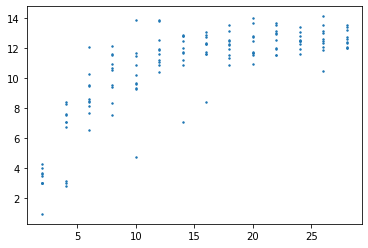

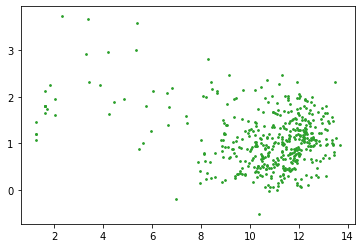

Iteration 1500
Loss v:  1.006, Loss p:  0.000, Loss s:  nan, Loss ssl:  0.022, Acc p:  1.000, Acc s:  nan    V Distance (target is +1):  0.802, std is:  0.562
Solved:  0.104
Length of Queue Hardlearner/Fellows/Stuck/WhileSolving: 11222 / 21409 / 0 / 0
Train Times of Queue Hardlearner/Fellows/Stuck/WhileSolving:  8.9 /  2.3 /  0.0 /  0.0


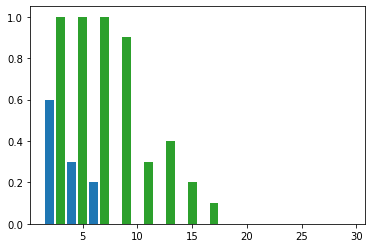

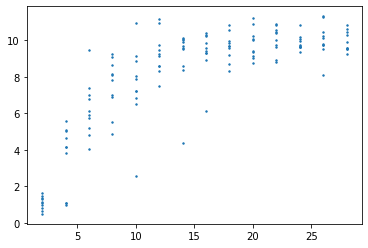

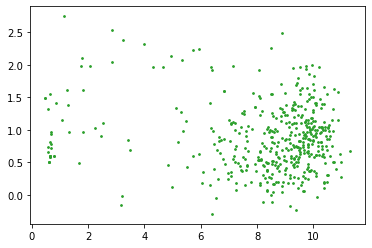

Iteration 1600
Loss v:  0.835, Loss p:  0.000, Loss s:  nan, Loss ssl:  0.016, Acc p:  1.000, Acc s:  nan    V Distance (target is +1):  1.153, std is:  0.426
Solved:  0.053
Length of Queue Hardlearner/Fellows/Stuck/WhileSolving: 9847 / 13923 / 0 / 0
Train Times of Queue Hardlearner/Fellows/Stuck/WhileSolving:  10.2 /  3.6 /  0.0 /  0.0


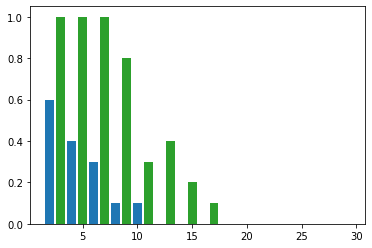

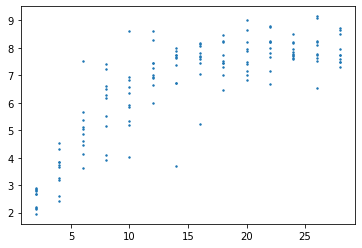

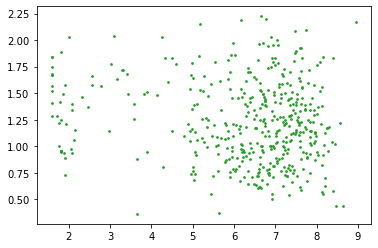

Iteration 1700
Loss v:  0.578, Loss p:  0.000, Loss s:  nan, Loss ssl:  0.011, Acc p:  1.000, Acc s:  nan    V Distance (target is +1):  0.678, std is:  0.374
Solved:  0.116
Length of Queue Hardlearner/Fellows/Stuck/WhileSolving: 8042 / 5749 / 0 / 0
Train Times of Queue Hardlearner/Fellows/Stuck/WhileSolving:  12.4 /  8.7 /  0.0 /  0.0


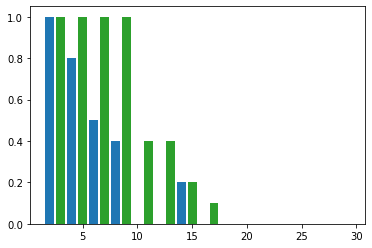

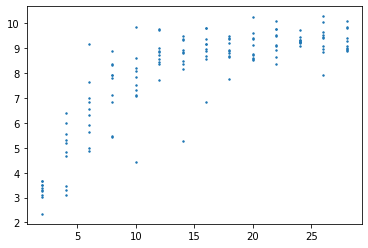

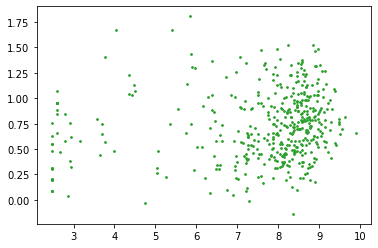

Iteration 1800
Loss v:  0.689, Loss p:  0.000, Loss s:  nan, Loss ssl:  0.013, Acc p:  1.000, Acc s:  nan    V Distance (target is +1):  1.183, std is:  0.577
Solved:  0.120
Length of Queue Hardlearner/Fellows/Stuck/WhileSolving: 7743 / 7045 / 0 / 0
Train Times of Queue Hardlearner/Fellows/Stuck/WhileSolving:  12.9 /  7.1 /  0.0 /  0.0


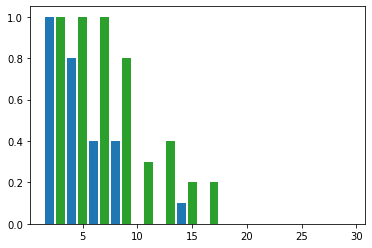

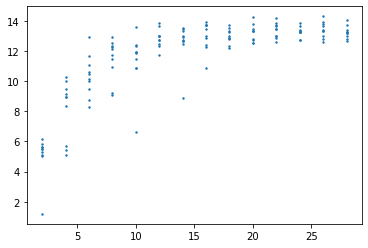

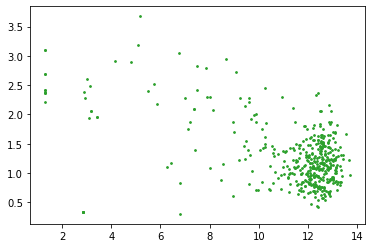

Iteration 1900
Loss v:  0.958, Loss p:  0.000, Loss s:  nan, Loss ssl:  0.015, Acc p:  1.000, Acc s:  nan    V Distance (target is +1):  1.293, std is:  0.589
Solved:  0.126
Length of Queue Hardlearner/Fellows/Stuck/WhileSolving: 8868 / 15292 / 0 / 0
Train Times of Queue Hardlearner/Fellows/Stuck/WhileSolving:  11.3 /  3.3 /  0.0 /  0.0


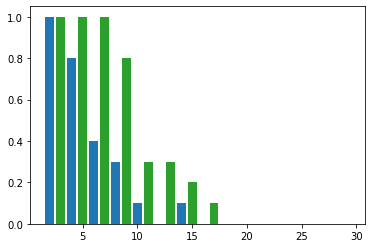

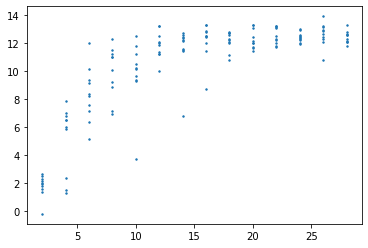

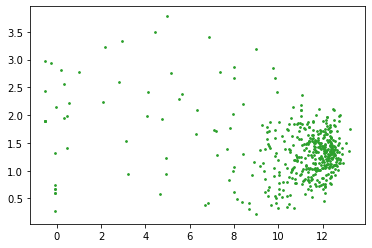

Iteration 2000
Loss v:  0.961, Loss p:  0.000, Loss s:  nan, Loss ssl:  0.016, Acc p:  1.000, Acc s:  nan    V Distance (target is +1):  1.333, std is:  0.557
Solved:  0.053
Length of Queue Hardlearner/Fellows/Stuck/WhileSolving: 9787 / 17438 / 0 / 0
Train Times of Queue Hardlearner/Fellows/Stuck/WhileSolving:  10.2 /  2.9 /  0.0 /  0.0


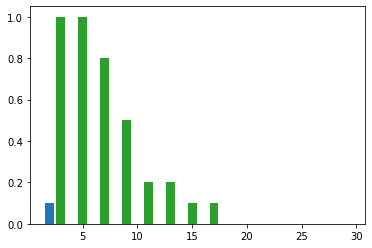

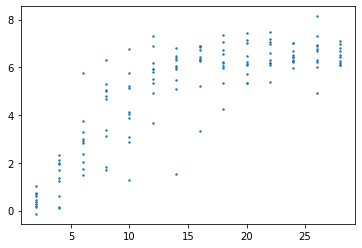

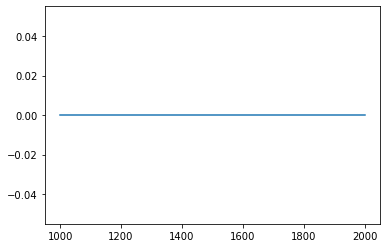

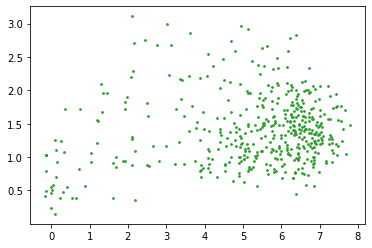

Saved to data/EXP_rubik_ep2.dat
Iteration 2100
Loss v:  0.512, Loss p:  0.000, Loss s:  nan, Loss ssl:  0.012, Acc p:  1.000, Acc s:  nan    V Distance (target is +1):  0.951, std is:  0.284
Solved:  0.025
Length of Queue Hardlearner/Fellows/Stuck/WhileSolving: 6557 / 6800 / 0 / 0
Train Times of Queue Hardlearner/Fellows/Stuck/WhileSolving:  15.3 /  7.4 /  0.0 /  0.0


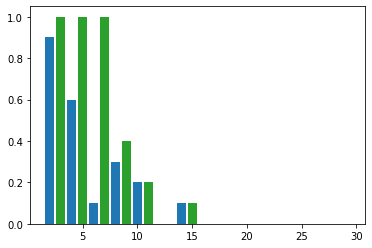

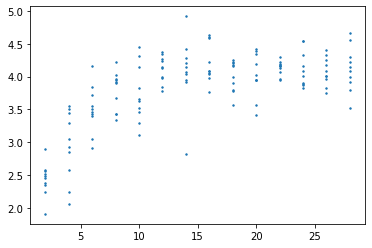

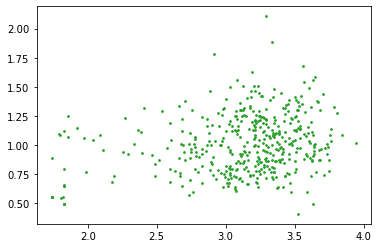

In [ ]:

iter0 = net.iter
#optimizer = torch.optim.Adam(lr=2e-4, betas=(0.8, 0.99), params=net.parameters(), weight_decay=1e-4)
optimizer = torch.optim.Adam(lr=5e-4, betas=(0.99, 0.999), params=net.parameters(), weight_decay=1e-4)
net_teacher = net.__class__()
net_teacher.load_state_dict(net.state_dict())
net_teacher.eval()


losses_p, losses_v, losses_s, losses_ssl, accs_p, accs_s, stuck_solved_stats, solved_lengths = [], [], [], [], [], [], [], []
queue_hardlearners = Queue()
queue_fellows = Queue()


ANN = 1e10 ## no annealing
#ANN = 300 ## annealing
if ANN < 1e6: print(f'Annealing in {ANN} steps')

# Initial Cube states
bnum = 500 # batch size           ###############
vs = np.ones(bnum)*np.inf  # value of states
xs = np.zeros((bnum,)+shape_state) # cube states in oh format
for i in range(bnum):
    xs[i] = state2oh(bg_shuffle())
histories = [ [] for i in range(bnum) ] # history of states while solving



for iter in trange(net.iter, int(1e10), initial=net.iter):

    last_vs = vs
    vsraw, ssraw, zs = fellow_vs(xs)
    
    ##### TESTPHASE: hashen von wenigen states
    count_in, count_out = 0, 0
    for b in range(bnum):
        state = oh2state(xs[b])
        for r in range(len(moves)):
            state2 = apply(state, moves[r])
            s2 = state.tobytes()
            if s2 in hashtable:
                ##print(vsraw[b,r], hashtable[s2])
                vsraw[b,r] = hashtable[s2]
                count_in += 1
            else:
                count_out += 1
    #print('In, out of hashtable: ', count_in, count_out)
    ##### END TESTPHASE

    # policies bestimmen und values bestimmen
    ps = np.argmin(vsraw, axis=1)
    vs = np.min(vsraw, axis=1)[:,None]
    vtarget = vs + 1
    for b in range(bnum):
        if issolved(xs[b]):
            vtarget[b] = 0.

    # Netzwerk lernen lassen durch die xs und (vs, ps)
    pred_vs = net(np2t(xs))
    loss_p = 0
    loss_v = L1L2(pred_vs, np2t(vtarget))
    loss = loss_p + loss_v
    losses_p += [0]
    losses_v += [loss_v.item()]
    acc_p = 1
    accs_p += [1]
    # Additional loss to calibrate the solved cube as zero
    v = net(tsolved[None,:])
    loss_solved = L1L2(v, torch.zeros_like(v))
    loss += 10*loss_solved
    pred_vs = t2np(pred_vs)
    vdist = [ pred_vs[k] - vs[k] for k in range(bnum)]



    # wenn v stark abweicht vom soll, dann sample speichern und wiederholt lernen
    for k in range(bnum//2):
        if pred_vs[k]-vs[k] > 1.5: # eigentlich sollte vdist = +1 sein, d. h. zu große Werte müssen korrigiert werden
            queue_hardlearners.add(xs[k])
        if pred_vs[k]-vs[k] < 0.5:
            queue_hardlearners.add(xs[k])
        for r in range(12):
            if vsraw[k,r]-pred_vs[k] > 1.5:
                queue_fellows.add(zs[k,r])


## Solved_length brauche ich nicht mehr
## stuck_solved_stats brauche ich nicht mehr
## histories usw.


    # Move anwenden auf die Cubes, oder aber mit neues States füllen, wenn stuck oder gelöst
    for b in range(bnum):
        verbose = False
        state0 = oh2state(xs[b])
        if b >= bnum//2:
            xs[b] = state2oh(bg_shuffle())
        else:
            s = state0.tobytes()
            #if s in hashtable:                                                                                              ######
            if issolved(state0):
                if verbose: print(f'State xs[0] is SOLVED after {len(histories[b])} moves! Filling with new state!')
                solved_lengths += [ len(histories[b]) ]
                #solved_lengths += [ len(histories[b]) + hashtable[s] ]                                                      ######
                histories[b].append(True)   # was solved
                stuck_solved_stats += [ True ]
                xs[b] = state2oh(bg_mixed())
                vs[b] = np.inf
            elif last_vs[b] < vs[b]:
                if verbose: print('State xs[0] is STUCK! Filling with new state!')
                histories[b].append(False)  # was not solved
                stuck_solved_stats += [ False ]
                xs[b] = state2oh(bg_mixed())
                vs[b] = np.inf
            else:
                if verbose: print(f'Applying move {moves[ps[b]]} on xs[0]')
                histories[b].append(xs[b].copy()) # alten state speichern
                state = apply(state0, moves[ps[b]])
                xs[b] = state2oh(state)
            if verbose:
                state = oh2state(xs[0])
                cube = state2cube(state)
                cube.draw()

                
    # History zum Netzwerk zum trainieren geben um zu lernen, welche States nun lösbar waren und welche nicht
    tempxs = []
    tempys = []
    for b in range(bnum):
        if len(histories[b])==0: continue
        if type(histories[b][-1]) is bool: # fertig gelöst oder stuck
            tempxs += histories[b][:-1]
            tempys += (len(histories[b])-1) * [ histories[b][-1] ]
            histories[b] = []
            

    #if ANN > 1e6:
        #if iter%50 == 24:
        #    solve_train(bg_inf(), trials=500) # den queues samples hinzufügen, die stuck sind
        #if iter%50 == 4:
        #    inds = argmax(abs(pred_ss-0.5)<0.3, num=10)
        #    enqueue_solvable_states(trials=1000, states=[xs[i] for i in inds]) # Queue mit lösbaren bzw. unlösbaren zuständen füllen
        #    enqueue_solvable_states(trials=1000, states=10)
        
       # for _ in range(10):
       #     add_to_stuck_queue(bg_mixed())
       # for _ in range(2):
       #     add_to_stuck_queue(bg_mixed(), depth=4)

    queue_hardlearners.train(bnum*2, weight=1.)  # bnum//4
    queue_fellows.train(bnum, weight=1.)           # bnum
    #queue_stuck.train(bnum//8, weight=0.05)
    #queue_solvable.train(bnum//100, weight=0.01)  ## vorerst ohne solvable

    queue_hardlearners.discount()
    queue_fellows.discount()
    queue_stuck.discount()
    #queue_solvable.discount()
    queue_while_solving.discount()


    # Trainiere so, dass ein Cube mit n verdrehungen maximal v<=n hat.
    train_upper_limit(bnum//8, weight=2.)
    train_lower_limit(bnum//2, weight=6.)
    l = train_ssl_consistency(n=bnum//20, weight=0.05)
    losses_ssl += [l.item()]
        
    if not ANN > 1e6:
        # Annealing if active (inactive if ann=inf)
        optimizer.param_groups[0]['lr'] = 2e-3 * (iter0+ANN-iter)**2/ANN**2    # learn rate decay
        if iter-iter0 == ANN: ValStats(extra=True); break
            
            
    # Backpropagation and update of the network
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    update_mt(net_teacher, net, 0.9)

    net.iter = iter

    # Verbose losses
    if iter%100 == 0:
        print(f'Iteration {iter}')
        print(f'Loss v: {np.mean(losses_v): .3f}, Loss p: {np.mean(losses_p): .3f}, Loss s: {np.mean(losses_s): .3f}, Loss ssl: {np.mean(losses_ssl): .3f}, Acc p: {np.mean(accs_p): .3f}, Acc s: {np.mean(accs_s): .3f}', end='    ')
        print(f'V Distance (target is +1): {np.mean(vdist): .3f}, std is: {np.std(vdist): .3f}')
        print(f'Solved: {np.mean(stuck_solved_stats): .3f}')
        print(f'Length of Queue Hardlearner/Fellows/Stuck/WhileSolving: {len(queue_hardlearners)} / {len(queue_fellows)} / {len(queue_stuck)} / {len(queue_while_solving)}')
        print(f'Train Times of Queue Hardlearner/Fellows/Stuck/WhileSolving: {queue_hardlearners.nTrainsPerSamples: .1f} / {queue_fellows.nTrainsPerSamples: .1f} / {queue_stuck.nTrainsPerSamples: .1f} / {queue_while_solving.nTrainsPerSamples: .1f}')
        losses_p, losses_v, losses_s, losses_ssl, accs_p, accs_s, stuck_solved_stats, solved_lengths = [], [], [], [], [], [], [], []
        ValStats(extra=(iter%1000 == 0))
        #plt.scatter(pred_vs, pred_ss, s=3); plt.show()
        plt.scatter(vs, vdist, s=3, c='C2'); plt.show()

    # Save checkpoints of this model
    if iter%1000 == 0:
        ep = iter//1000
        fn = f'data/EXP_rubik_ep{ep}.dat'
        torch.save(net.state_dict(), fn)
        print(f'Saved to {fn}')


In [ ]:
[
    .4,
    .55,
    .6,
    .45,
    .6,
    .6,
    .65,
    .55,
    .7,
    .4,
    .5,
    .3,
    .75,  # <-- epoche 13
    .6,
    .4,
    .7,
    .6,
    .5
]

In [ ]:
ValStats()

In [ ]:
ep = iter//1000
fn = f'data/rubik_ep{ep}_annealed.dat'
torch.save(net.state_dict(), fn)
print(f'Saved to {fn}')

In [ ]:
with open('data/queue_while_solving.pkl', 'wb') as f:
    pickle.dump(queue_while_solving.samples, f)
with open('data/queue_stuck.pkl', 'wb') as f:
    pickle.dump(queue_stuck.samples, f)

## Zur Lösung anwenden

In [ ]:
class GetOutOfLoop(Exception):
    pass
    
def solve(state0, verbose=2, maxlen=100, batchsize=10, trials=100000):
    'maxlen: Maximal erlaubte Länge der Lösung'
    # batchsize von > 10 kann suboptimale sein und bringt keinen geschwindigkeitsvorteil(?)
    
    res = dict()
    
    def verb(*args):
        if verbose>=1: print(*args)
    
    @lru_cache(None)
    def penalty(l, t):
        #return log(l+1)*t*15 # return penalty dependent on parameter t
        #return 0.0*l*t # für kurze lösungen schneller
        return 0.8*l*t # für schnelleres finden allgemein
        
    def penalties(v, ms):
        l = len(ms)
        return [v + penalty(l, t) for t in np.arange(0, 1, 1/5)]
    
    try: state0 = oh2state(state0)
    except: pass
    
    v0 = net(np2t(state2oh(state0)[None,:]), policy=False).item()
    
    explored = set()
    queue = SolvingQueue(n=5)
    queue.push(item=(state0, v0, ''), values=5*[0])
    
    basestate0 = state0
    
    iter = 0
    
    try:
        
        while len(queue)>0:

            bsize = min(batchsize, len(queue)) # batch size is small at the beginning and can become bigger
            newstates = []
            ms = []

            for b in range(bsize):

                while True: # Take state out of queue that fulfills the maxlen constraint
                    if len(queue)==0:
                        verb(f'Aborting after {iter} trials due to empty queue!')
                        res['trials'] = iter
                        res['ms'] = -1
                        res['l'] = -1
                        return res
                    state0, v0, m0 = queue.pop(iter%5)
                    if len(m0) + 0.8*(v0-hashed_depth) - 0.5 < maxlen - hashed_depth: # erwartete lösungslänge vs. erlaubtes maximum
                        break

                verb(f'Iteration {iter}, Moves {m0} applied, Value = {v0}, len(queue) = {len(queue)}!')

                if iter%22==0 and b==0 and verbose>=2: draw(state0)
        
                s = state0.tobytes()
                if s in hashtable:
                    m0 += inverse_moves(mashtable[s])
                    verb(f'Cube is solved after {len(m0)} moves and {iter} trials!')
                    raise GetOutOfLoop
                    
                if issolved(state0):
                    verb(f'Cube is solved after {len(m0)} moves and {iter} trials!')
                    raise GetOutOfLoop
                    #print(f'Cube is solved after {len(m0)} moves and {iter} trials! Trying with a move less')
                    #maxlen -= 1
                    #continue

                # Auf jeden Würfel in xs die zwölf Züge anwenden und in zs speichern
                for m in moves:
                    newstates.append(apply(state0, m))
                    ms.append(m0+m)
                    
                iter += 1
                
                if iter >= trials:
                    verb(f'Aborting after {iter} trials')
                    res['trials'] = iter
                    res['ms'] = -1
                    res['l'] = -1
                    return res
                

            # Auf zs das Netzwerk anwenden und die Values in vs speichern (Vorhersage des Netzwerkes für den 'Wert' eines Status, d.h. wie nahe ein Status an dem gelösten Cube ist.)
            zs = np.array([ state2oh(s) for s in newstates ])
            with torch.no_grad():
                zs = np2t(zs)
                vsnext = net(zs, policy=False)
                vsnext  = t2np(vsnext[:,0])

            # Neue States der Queue hinzufügen
            for k in range(12*bsize):
                if newstates[k].tobytes() in explored:
                    continue
                else:
                    explored.add(newstates[k].tobytes())
                    queue.push(item=(newstates[k], vsnext[k], ms[k]), values=penalties(vsnext[k], ms[k]))
            
            
    except GetOutOfLoop:
        
        if verbose>=1:
            # print solving sequence of cubes
            cube = state2cube(basestate0)
            cube.draw()
            for m in m0:
                print(f'------------ Applying move {m} ------------')
                cube.rotate(m)
                cube.draw()
        if verbose>0:
            print(f'Cube is solved after {len(m0)} moves and {iter} trials!')

        res['ms'] = m0
        res['l'] = len(m0)
        res['trials'] = iter
        return res

In [ ]:
# checken, wie wie schweren samples schneller gelöst werden können
inds = [ i for i in range(len(T)) if T[i] > 10 ]

for i in inds[0:4]:
    print(tr[i])
    solve(valbatch[i], maxlen=35, verbose=.1, batchsize=10)

In [ ]:
def solve_best(state, verbose=1, maxlenstart=28, ntrials=100000, batchsize=10):
    'Tries to find the minimal solution length'
    maxlen = maxlenstart
    delml = 2
    l, ms = np.inf, ''
    trials = 0
    while True:
        if verbose: print('Maxlen =', maxlen)
        res = solve(state, maxlen=maxlen, verbose=(.1*verbose), trials=ntrials, batchsize=batchsize)
        if res['l'] < 0:
            maxlen += 2 # for parity reasons a step of 2 is reasonable
            if maxlen >= l: break
        else:
            trials += res['trials']
            l = res['l']
            ms = res['ms']
            maxlen = l-delml
    return { 'l': l, 'ms': ms, 'trials': trials }

In [ ]:
#%load_ext line_profiler
#%lprun -f solve solve(valbatch[0], maxlen=35, verbose=.1, batchsize=10)
%lprun -f SolvingQueue.push solve(valbatch[0], maxlen=35, verbose=.1, batchsize=10)

In [ ]:
np.random.seed(0)
valbatch = []
for k in trange(640):
    state = shuffle(n=1000)
    valbatch.append(state2oh(state))
valbatch = np.array(valbatch)

In [ ]:
ep=3
#ep=22
ep=32
#ep=13
fn = f'data/rubik_ep{ep}_annealed.dat'
d = torch.load(fn)
print(f'Loading Network form path "{fn}"')
net = Net()
net.load_state_dict(d)
net.iter = 1000*ep+1
net_teacher = net

In [ ]:
# real world randomly shuffled cube
input = \
''' yyy
    yyy
    yyy
gog oro bbb rgr
ggg ooo bbb rrr
ggg ooo bbb rrr
    www
    www
    www
'''
input = \
''' yyw
    oyb
    ygw
rgo byg rro gbb
ggr yoo bbo yrr
bgg rog ybw bro
    ywo
    www
    wwr
'''

input = \
''' yyy
    yyy
    gyb
ggo yoy obb rrr
ggg ooo bbb rrr
ggg ooo bbb rrr
    www
    www
    www
'''# LLbLflBLLulUFuLU

input = \
''' yyy
    yyy
    yyy
gbb roo bgg orr
ggg ooo bbb rrr
ggg ooo bbb rrr
    www
    www
    www
'''

cube.fromstring(input)
cube.draw()

#cube.reset()
#cube.rotate('FURurf') # Fw R U Ri Ui Fwi F R U Ri Ui Fi

mystate = cube2state(cube)

#solve_best(mystate, maxlenstart=14, batchsize=10, ntrials=500000)
solve(mystate, maxlen=34, trials=np.inf)

In [ ]:


input = \
''' oor
    ryb
    ywo
byr grb yrb wgw
ogb wog rbw orb
wyr bog wyy owo
    yyr
    gwb
    ggg
'''

cube.fromstring(input)
cube.draw()
mystate = cube2state(cube)

#solve_best(mystate, maxlenstart=14, batchsize=10, ntrials=500000)
solve(mystate, maxlen=30, trials=np.inf)

In [ ]:
#res = solve_best(mystate26)
solve(mystate26, maxlen=26, verbose=1, trials=np.inf)

In [ ]:
from time import time
print('starting')

T, L, tr = [], [], []
for i in range(640):
    t0 = time()
    res = solve(valbatch[i], maxlen=35, verbose=.1, batchsize=10)
    #res = solve_best(valbatch[i], maxlenstart=26)
    t1 = time()
    T.append(t1-t0)
    L.append(res['l'])
    tr.append(res['trials'])
    print(f'Solved in {t1-t0: .3f} s')
    if i%10 == 0:
        print(f'-- Cubes Number {i} --')
        print(f'-- Median of T is  {np.median(T): .03f} --')
        print(f'-- Mean   of T is  {np.mean(T): .03f} --')
        print(f'-- Max    of T is  {np.max(T): .03f} --')
        print(f'-- Median of L is  {np.median(L): .03f} --')
        print(f'-- Mean   of L is  {np.mean(L): .03f} --')
        print(f'-- Max    of L is  {np.max(L): .03f} --')
        print(f'-- Median of tr is {np.median(tr): } --')
        print(f'-- Mean   of tr is {np.mean(tr): .03f} --')
        print(f'-- Max    of tr is {np.max(tr)} --')
        print()

In [ ]:

#  rubik_ep13_annealed.dat
-- Cubes Number 10 --
-- Median of T is   1.556 --
-- Mean   of T is   2.340 --
-- Max    of T is   8.657 --
-- Median of L is   28.000 --
-- Mean   of L is   29.455 --
-- Max    of L is   36.000 --
-- Median of tr is  1501.0 --
-- Mean   of tr is  2373.636 --
-- Max    of tr is  8492 --

#  rubik_ep18_annealed.dat
-- Cubes Number 10 --
-- Median of T is   0.984 --
-- Mean   of T is   2.530 --
-- Max    of T is   11.640 --
-- Median of L is   32.000 --
-- Mean   of L is   30.909 --
-- Max    of L is   34.000 --
-- Median of tr is  846.0 --
-- Mean   of tr is  1599.182 --
-- Max    of tr is  8371 --

#  rubik_ep32_annealed.dat
-- Cubes Number 10 --
-- Median of T is   1.569 --
-- Mean   of T is   2.679 --
-- Max    of T is   9.997 --
-- Median of L is   28.000 --
-- Mean   of L is   29.455 --
-- Max    of L is   36.000 --
-- Median of tr is  1373.0 --
-- Mean   of tr is  2370.545 --
-- Max    of tr is  9291 --

#  rubik_ep3_annealed.dat
-- Cubes Number 10 --
-- Median of T is   1.867 --
-- Mean   of T is   3.435 --
-- Max    of T is   13.060 --
-- Median of L is   30.000 --
-- Mean   of L is   30.909 --
-- Max    of L is   38.000 --
-- Median of tr is  1771.0 --
-- Mean   of tr is  3231.273 --
-- Max    of tr is  12579 --


#  rubik_ep22_annealed.dat
-- Cubes Number 10 --
-- Median of T is   2.059 --
-- Mean   of T is   2.347 --
-- Max    of T is   5.595 --
-- Median of L is   32.000 --
-- Mean   of L is   31.273 --
-- Max    of L is   36.000 --
-- Median of tr is  2095.0 --
-- Mean   of tr is  2433.727 --
-- Max    of tr is  5857 --

In [ ]:
mit run3/rubik_ep32_annealed.dat (trainiert in 13 stunden):
-- Cubes Number 190 --
-- Median of T is   1.230 --
-- Mean   of T is   2.350 --
-- Max    of T is   20.610 --
-- Median of L is   32.000 --
-- Mean   of L is   31.152 --
-- Max    of L is   34.000 --
-- Median of tr is  1591.0 --
-- Mean   of tr is  2978.696 --
-- Max    of tr is 25111 --

In [ ]:

-- Cubes Number 10 --
-- Median of T is  9.507
-- Mean   of T is  16.395
-- Max    of T is  68.647
-- Median of L is  28.000 --
-- Mean   of L is  27.636 --




-- Cubes Number 10 --
-- Median of T is  7.566
-- Max    of T is  37.598
-- Median of L is  36.000 --


-- Cubes Number 10 --
-- Median of T is  11.660
-- Max    of T is  49.955
-- Median of L is  36.000 --


mystate26:
Cube is solved after 26 moves and 101541 trials! (mit 0.8*l*t)
Cube is solved after 26 moves and  30081 trials! = 38.5s (mit 0.*l*t)


In [ ]:
import seaborn as sns
sns.distplot(T)
plt.show()
sns.boxplot(y=T)
plt.show()
sns.boxplot(y=L)
plt.ylim([0, 55])

## Nach wie vielen Shuffels ist Gleichverteilung erreicht?

In [ ]:
# Nach wie vielen shuffels ist der limes erreicht?
nshuffles = [20, 30, 50, 100, 400, 1000, 10000]
#d = dict()

In [ ]:
while True:
    # add n to dict if not there yet
    for n in nshuffles:
        if n not in d: d[n] = []
            
    n = min(nshuffles, key=lambda n: len(d[n]))
    print(f'Shuffled {n} times')
    res = solve_best(shuffle(n=n), verbose=0, ntrials=100000, batchsize=10)
    d[n].append(res['l'])
    print(f"Solved after {res['l']} moves")
    print(''.join([ f'l[{n}] = {np.mean(d[n]): .02f} +- {np.std(d[n])/(np.sqrt(len(d[n]))+1e-4): .02f};  ' for n in nshuffles ]))
    
    
''' Ab n=50 ist der Würfel vollständig zufällig
l[20] =  17.84 +-  0.45;
l[30] =  22.83 +-  0.25;
l[50] =  23.62 +-  0.16;
l[100] =  23.50 +-  0.16;
l[400] =  23.27 +-  0.14;
l[1000] =  23.56 +-  0.17;
l[10000] =  23.54 +-  0.14;
'''

In [ ]:
nets = []
for ep in [28, 30, 32]:
#for ep in [30]:
    fn = f'data/rubik_ep{ep}.dat'
    d = torch.load(fn)
    print(f'Loading Network form path "{fn}"')
    net = Net()
    net.load_state_dict(d)
    net.iter = 1000*ep+1
    net_teacher = net

    nets.append(net)

In [ ]:
def net(*args, **kwargs):
    return torch.mean(torch.stack(([n(*args, **kwargs) for n in nets])), dim=0)


In [ ]:

#state = shuffle(n=20)

solve(state, maxlen=20, verbose=1, trials=np.inf)

# nur ep28: Cube is solved after 20 moves and 3741 trials!
# nur ep30: Cube is solved after 20 moves and 18951 trials!
# nur ep32: Cube is solved after 20 moves and 32421 trials!

# ensemble: Cube is solved after 20 moves and 10421 trials!

In [ ]:
ms = 'FrurUflbufUflUdRluBLDldbULUbuB'
for k in range(len(ms)-hashed_depth):
    sub_ms = ms[k:k+hashed_depth]
    state = newstate()
    state = apply(state, sub_ms)
    real = hashtable[state.tobytes()]
    print(len(sub_ms), real)